In [21]:
import numpy as np
import pandas as pd

In [22]:
df = pd.read_csv("stocks_signal_yiyanghkust.csv", header= [0])

In [23]:
df.head()

Unnamed: 0        Date Ticker        Open        High         Low  \
0           0  2024-03-11      A  146.668570  147.937054  144.805478   
1           1  2024-03-11    ABT  117.968327  118.446324  116.690412   
2           2  2024-03-11    ACN  366.420406  367.575311  359.265824   
3           3  2024-03-11    ADM   52.694976   53.533242   52.675705   
4           4  2024-03-11    AEE   70.142268   70.919704   70.113475   

        Close     Volume  sentiment  
0  145.964951  1397600.0        NaN  
1  117.246452  3886000.0        NaN  
2  365.285065  2220000.0        NaN  
3   52.906952  5209600.0        NaN  
4   70.689354  1578300.0        NaN

In [24]:
df = df.drop(columns="Unnamed: 0")
df.head()

Date Ticker        Open        High         Low       Close  \
0  2024-03-11      A  146.668570  147.937054  144.805478  145.964951   
1  2024-03-11    ABT  117.968327  118.446324  116.690412  117.246452   
2  2024-03-11    ACN  366.420406  367.575311  359.265824  365.285065   
3  2024-03-11    ADM   52.694976   53.533242   52.675705   52.906952   
4  2024-03-11    AEE   70.142268   70.919704   70.113475   70.689354   

      Volume  sentiment  
0  1397600.0        NaN  
1  3886000.0        NaN  
2  2220000.0        NaN  
3  5209600.0        NaN  
4  1578300.0        NaN

In [25]:
dupes = df[df.duplicated(subset=['Date', 'Ticker'], keep=False)]
print(dupes)

Empty DataFrame
Columns: [Date, Ticker, Open, High, Low, Close, Volume, sentiment]
Index: []


In [26]:
# DataFrame assumed: df with 'Date', 'Ticker', 'Close', 'sentiment'
df = df.sort_values(['Date', 'Ticker']).copy()
df['Date'] = pd.to_datetime(df['Date'])

# Pivot to get time-series of Close prices and sentiments
price_pivot = df.pivot(index='Date', columns='Ticker', values='Close')
sent_pivot = df.pivot(index='Date', columns='Ticker', values='sentiment')

# Calculate forward 1-day returns
returns = price_pivot.pct_change().shift(-1)

# Initialize tracking
daily_pnl = []
current_longs = []
current_shorts = []

# Iterate over all dates except last (no forward return on last day)
for date in sent_pivot.index[:-1]:
    sentiments = sent_pivot.loc[date]
    valid = sentiments.dropna()

    # Rebalance if we have enough signals
    if len(valid) >= 20:
        ranked = valid.sort_values(ascending=False)
        n = len(ranked)
        top_n = int(np.floor(0.15 * n))
        bottom_n = int(np.floor(0.15 * n))

        current_longs = ranked.iloc[:top_n].index.tolist()
        current_shorts = ranked.iloc[-bottom_n:].index.tolist()

    # Compute P&L from positions
    rtns = returns.loc[date]

    pnl_long = rtns[current_longs].mean() if current_longs else 0
    pnl_short = -rtns[current_shorts].mean() if current_shorts else 0
    net_pnl = pnl_long + pnl_short  # Net return per $2 invested

    daily_pnl.append(net_pnl)

# Convert to Series and compute metrics
pnl_series = pd.Series(daily_pnl, index=sent_pivot.index[:-1])
cum_return = (1 + pnl_series).cumprod()
annualized_return = (cum_return.iloc[-1])**(252 / len(cum_return)) - 1
sharpe_ratio = (pnl_series.mean() / pnl_series.std()) * np.sqrt(252)

print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Annualized Return: -16.89%
Sharpe Ratio: -2.02


In [27]:
# Step 1: Compute current daily volatility
daily_vol = pnl_series.std()

# Step 2: Compute target daily volatility (15% annualized)
target_daily_vol = 0.15 / np.sqrt(252)

# Step 3: Scale daily returns
scaled_returns = pnl_series * (target_daily_vol / daily_vol)

# Step 4: Compute new cumulative return
scaled_cum_return = (1 + scaled_returns).cumprod()

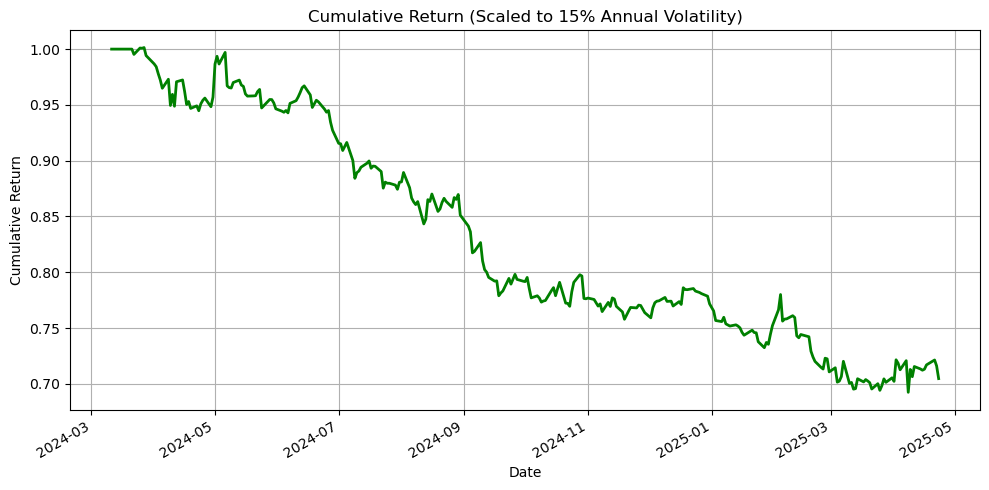

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
scaled_cum_return.plot(color='green', linewidth=2, title='Cumulative Return (Scaled to 15% Annual Volatility)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Save checkpoint
scaled_cum_return.to_pickle("yiyanghkust_checkpoint_scaled_cum_return.pkl")

### Combine all the figures

In [30]:
import matplotlib.pyplot as plt

<Figure size 1200x1000 with 0 Axes>

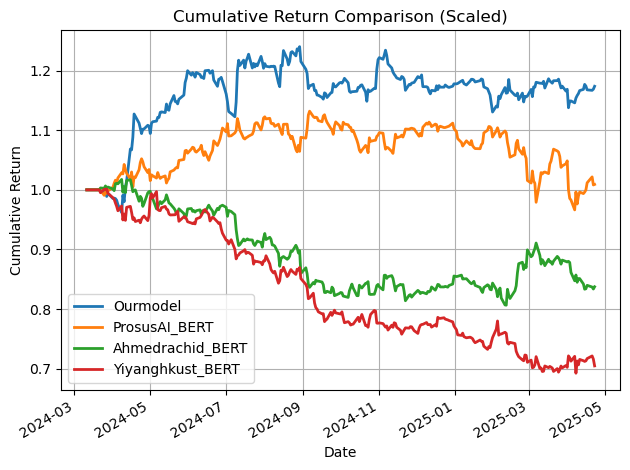

In [34]:
# Step 1: Load the checkpointed Series
cum1 = pd.read_pickle("ourmodel_checkpoint_scaled_cum_return.pkl")
cum2 = pd.read_pickle("ProsusAI_checkpoint_scaled_cum_return.pkl")
cum3 = pd.read_pickle("ahmedrachid_checkpoint_scaled_cum_return.pkl")
cum4 = pd.read_pickle("yiyanghkust_checkpoint_scaled_cum_return.pkl")

# Step 2: Combine into a single DataFrame
df_combined = pd.concat([cum1.rename("Ourmodel"),
                         cum2.rename("ProsusAI_BERT"),
                         cum3.rename("Ahmedrachid_BERT"), 
                         cum4.rename("Yiyanghkust_BERT")], axis=1)

# Step 3: Plot
plt.figure(figsize=(12, 10))
df_combined.plot(title="Cumulative Return Comparison (Scaled)", linewidth=2)
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()